Installing the necessary packages

In [2]:
# !pip install -q segmentation-models-pytorch
# !pip install -q pytorch-lightning
# !pip install -q GPUtil

Making the imports

In [3]:
import torch
import os
import ssl
import segmentation_models_pytorch as smp
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
import multiprocessing as mp
from torch import nn
from segmentation_models_pytorch.encoders import get_preprocessing_fn
from GPUtil import showUtilization as gpu_usage
import pandas as pd
from pytorch_lightning.loggers import CSVLogger

Assuring that the GPU has it memory free

In [4]:
torch.cuda.empty_cache()
gpu_usage()

| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |


Defining global variables

In [5]:
ENCODER = 'efficientnet-b2'
ENCODER_WEIGHTS = 'imagenet'
CHANNELS = 3
CLASSES = 2
ACTIVATION = 'sigmoid'
LR = 0.001
BATCH_SIZE = 8
IMG_SIZE = (224,224)
DEVICE, NUM_DEVICES = ("cuda", torch.cuda.device_count()) if torch.cuda.is_available() else ("cpu", mp.cpu_count())
WORKERS = mp.cpu_count()
print(f'Running on {NUM_DEVICES} {DEVICE}(s)')

LR = 0.001
EPOCHS = 3
OUTPUT_DIR = '/kaggle/working/'

Running on 1 cuda(s)


Determining the training, validation and test sets using pandas

In [6]:
DATA_DIR = '/kaggle/input/isndata/preprocessed'

metadata_df = pd.read_csv("/kaggle/input/isndata/preprocessed/metadata.csv")
metadata_df = metadata_df[metadata_df['split']=='experiment']
metadata_df = metadata_df[['image_id', 'image_path', 'mask_path']]
metadata_df['image_path'] = metadata_df['image_path'].apply(lambda img_pth: os.path.join(DATA_DIR, img_pth))
metadata_df['mask_path'] = metadata_df['mask_path'].apply(lambda img_pth: os.path.join(DATA_DIR, img_pth))
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)

valid_df = metadata_df.sample(frac=0.1, random_state=42)
minus_valid_df = metadata_df.drop(valid_df.index)
test_df = minus_valid_df.sample(frac=0.1, random_state=42)
train_df = minus_valid_df.drop(test_df.index)

len(train_df), len(valid_df), len(test_df)

(729, 90, 81)

Determining class names and rgb related colors

In [7]:
class_df = pd.read_csv(os.path.join(DATA_DIR, 'class_dict.csv'))
class_names = class_df['name'].tolist()
class_rgb_values = class_df[['r','g','b']].values.tolist()

print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

All dataset classes and their corresponding RGB values in labels:
Class Names:  ['rectangle', 'unknown']
Class RGB values:  [[255, 255, 255], [0, 0, 0]]


Helper functions to perform the one hot transformation on the masks. This is needed because the masks are multiclass rgb files.

In [8]:
def one_hot_encode(label, label_values):
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)
    return semantic_map

Implementing the Segmentation Model Class (subclassing pl.LightningModule)

In [9]:
class SegmentationModel(pl.LightningModule):
    def __init__(self, net, loss, lr):
        super().__init__()
        self.save_hyperparameters()
        self.lr = lr
        self.loss = loss
        self.net = net

    def forward(self, x):
        return self.net(x)

    def shared_step(self, preds, labels):
        tp, fp, fn, tn = smp.metrics.get_stats(preds, labels.long(), mode='binary', threshold=0.5)

        iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
        accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")
        recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro-imagewise")

        return {'iou_score': iou_score,
                'f1_score': f1_score,
                'accuracy': accuracy,
                'recall': recall}

    def training_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self(imgs)

        metrics = self.shared_step(preds, labels)

        self.log('train_iou_score', metrics['iou_score'], on_epoch=True)     
        self.log('train_f1_score', metrics['f1_score'], on_epoch=True)     
        self.log('train_accuracy', metrics['accuracy'], on_epoch=True)     
        self.log('train_recall', metrics['recall'], on_epoch=True)     

        loss = self.loss(preds, labels)
        self.log("train_loss", loss)
        return loss  

    def validation_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self(imgs)

        metrics = self.shared_step(preds, labels)

        self.log('valid_iou_score', metrics['iou_score'], on_epoch=True)     
        self.log('valid_f1_score', metrics['f1_score'], on_epoch=True)     
        self.log('valid_accuracy', metrics['accuracy'], on_epoch=True)     
        self.log('valid_recall', metrics['recall'], on_epoch=True)

        loss = self.loss(preds, labels)
        self.log("valid_loss", loss)             

    def test_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self(imgs)

        metrics = self.shared_step(preds, labels)

        self.log('test_iou_score', metrics['iou_score'], on_epoch=True)     
        self.log('test_f1_score', metrics['f1_score'], on_epoch=True)     
        self.log('test_accuracy', metrics['accuracy'], on_epoch=True)     
        self.log('test_recall', metrics['recall'], on_epoch=True)

        loss = self.loss(preds, labels)
        self.log("test_loss", loss) 
        
    def configure_optimizers(self):
        opt = torch.optim.Adam(self.net.parameters(), lr=self.lr)
        return [opt]

Implementing the ISN Dataset Class (subclassing Dataset)

In [ ]:
class ISNSet(Dataset):
    def __init__(self, df, transform=None, preprocess_fn=None, class_rgb_values=None):
        self.image_paths = df['image_path'].tolist()
        self.mask_paths = df['mask_path'].tolist()
        self.transform = transform
        self.preprocess_fn = preprocess_fn
        self.class_rgb_values = class_rgb_values

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_file = self.image_paths[idx]
        mask_file = self.mask_paths[idx]

        img = Image.open(img_file).convert('RGB')
        img = np.array(img)

        mask = Image.open(mask_file).convert('RGB')
        
        # one-hot-encode the mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')

        if self.preprocess_fn:
            img = self.preprocess_fn(img)
            img = np.array(img, dtype=np.float32)

        if self.transform:
            img = self.transform(img)
            mask = self.transform(mask)

        return img, mask

Implementing the ISN DataModule Class (subclassing pl.LightningDataModule)

In [11]:
class ISNDataModule(pl.LightningDataModule):
    def __init__(self, train_df, valid_df, test_df, batch_size=2, img_size=(256,256), preprocess_fn=None, class_rgb_values=None):
        super().__init__()
        self.train_df = train_df
        self.valid_df = valid_df
        self.test_df = test_df
        self.batch_size = batch_size
        self.img_size = img_size
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize(size=self.img_size),
        ])
        self.preprocess_fn = preprocess_fn
        self.class_rgb_values = class_rgb_values

    def setup(self, stage=None):
        self.trainset = ISNSet(self.train_df, transform=self.transform, preprocess_fn=self.preprocess_fn, class_rgb_values=self.class_rgb_values)
        self.validset = ISNSet(self.valid_df, transform=self.transform, preprocess_fn=self.preprocess_fn, class_rgb_values=self.class_rgb_values)
        self.testset = ISNSet(self.test_df, transform=self.transform, preprocess_fn=self.preprocess_fn, class_rgb_values=self.class_rgb_values)

    def train_dataloader(self):
        return DataLoader(self.trainset, batch_size=self.batch_size, shuffle=True, num_workers=WORKERS, pin_memory=True)

    def val_dataloader(self):
        return DataLoader(self.validset, batch_size=self.batch_size, shuffle=False, num_workers=WORKERS, pin_memory=True)

    def test_dataloader(self):
        return DataLoader(self.testset, batch_size=self.batch_size, shuffle=False, num_workers=WORKERS, pin_memory=True)

* Defining the net that will be used in our model (Unet++)
* Defining the loss function
* Defining the optimizer

In [12]:
ssl._create_default_https_context = ssl._create_unverified_context

net = smp.UnetPlusPlus(
    encoder_name=ENCODER,                
    encoder_weights=ENCODER_WEIGHTS,     
    in_channels=CHANNELS,                       
    classes=CLASSES,                          
    activation= ACTIVATION                  
)

preprocess_input = get_preprocessing_fn(ENCODER, pretrained=ENCODER_WEIGHTS)

LOSS = nn.CrossEntropyLoss()

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b2-8bb594d6.pth


  0%|          | 0.00/35.1M [00:00<?, ?B/s]

Defining our trainer

In [13]:
early_stop_callback = EarlyStopping(
    monitor='valid_loss', 
    min_delta=0.00001, 
    patience=5, 
    mode='min')

checkpoint_callback = ModelCheckpoint(
    every_n_epochs=1,
    dirpath=OUTPUT_DIR,
    filename='lightning_trained'
)

logger = CSVLogger(OUTPUT_DIR, name='lightning_logs')

trainer = pl.Trainer(
        accelerator=DEVICE,
        devices=NUM_DEVICES,
        max_epochs=EPOCHS,
        callbacks=[early_stop_callback, checkpoint_callback],
        logger=logger,
    )

Instantiating the model and the data module

In [14]:
segmodel = SegmentationModel(net, LOSS, LR)
isndata = ISNDataModule(train_df, valid_df, test_df, BATCH_SIZE, IMG_SIZE, preprocess_input, class_rgb_values)

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.
  f"Attribute {k!r} is an instance of `nn.Module` and is already saved during checkpointing."
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  f"Attribute {k!r} is an instance of `nn.Module` and is already saved during checkpointing."


Running our training based on a previously saved checkpoint if available, otherwise we start from scratch.
This is also useful to load our model from a checkpoint.

In [15]:
CHECKPOINT_DIR = '../input/savedckpt/'
checkpoint_file = os.path.join(CHECKPOINT_DIR, 'lightning_trained-v1.ckpt') 

if os.path.isfile(checkpoint_file):
    print('Resuming training from previous checkpoint...')
    trainer.fit(segmodel, datamodule=isndata,
                ckpt_path=checkpoint_file)
else:
    print('Starting training from scratch...')
    trainer.fit(segmodel, datamodule=isndata)

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint directory /kaggle/working exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Starting training from scratch...


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Loading our checkpoint and testing it.

In [16]:
# CHECKPOINT_DIR = '../input/saved-checkpoints/'
# checkpoint_file = os.path.join(CHECKPOINT_DIR, 'lightning_trained-v1.ckpt')

# segmodel = SegmentationModel.load_from_checkpoint(checkpoint_file)

# isndata = ISNDataModule(train_df, valid_df, test_df, 
#                                     BATCH_SIZE, IMG_SIZE, 
#                                     preprocess_input, class_rgb_values)

trainer.test(segmodel, datamodule=isndata)

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9984359741210938     │
│       test_f1_score       │    0.9984359741210938     │
│      test_iou_score       │    0.9968776106834412     │
│         test_loss         │    0.31733827502809175    │
│        test_recall        │    0.9984479546546936     │
└───────────────────────────┴───────────────────────────┘

[{'test_iou_score': 0.9968776106834412,
  'test_f1_score': 0.9984359741210938,
  'test_accuracy': 0.9984359741210938,
  'test_recall': 0.9984479546546936,
  'test_loss': 0.31733827502809175}]

Helper function to visualize the data

In [ ]:
def reverse_one_hot(image):
    x = np.argmax(image, axis = 0)
    return x

# def reverse_one_hot(image):
#     x = np.argmax(image, axis=-1)  # Ensure correct axis is used
#     return x


def colour_code_segmentation(image, label_values):
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]
    return x

# def colour_code_segmentation(image, label_values):
#     colour_codes = np.array(label_values)
#     max_index = len(colour_codes) - 1
#     # Clip indices to ensure they are within the valid range
#     image = np.clip(image, 0, max_index)
#     x = colour_codes[image.astype(int)]
#     return x


In [17]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

Instantiating a test dataset for visualization (i.e without preprocessing function)

In [18]:
# Testeset sem o preprocessamento para fins de visualização 
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size=IMG_SIZE),
])

testset = ISNSet(test_df, transform=transform, preprocess_fn=preprocess_input, class_rgb_values=class_rgb_values)
testsetvis = ISNSet(test_df, transform=transform, preprocess_fn=None, class_rgb_values=class_rgb_values)

reverse_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(size=IMG_SIZE),
        ])

Visualizing the predictions

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == "":


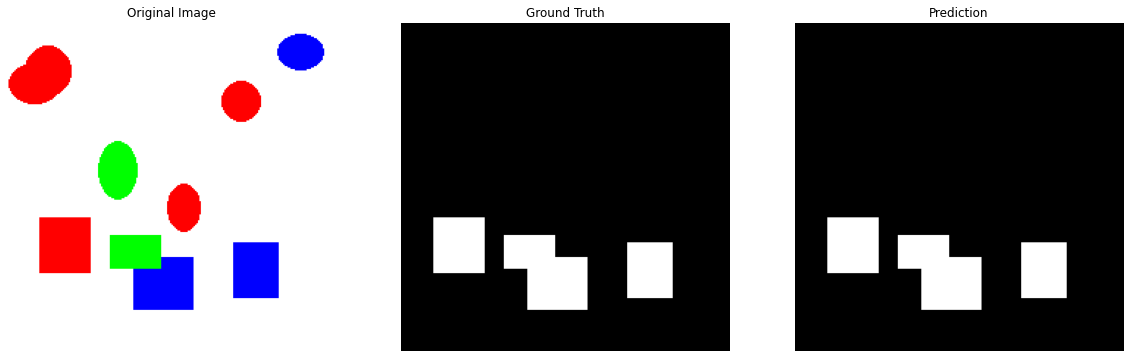

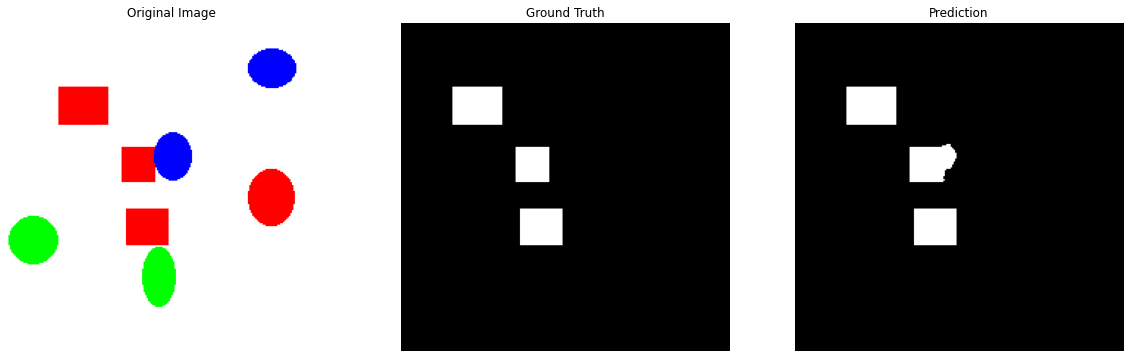

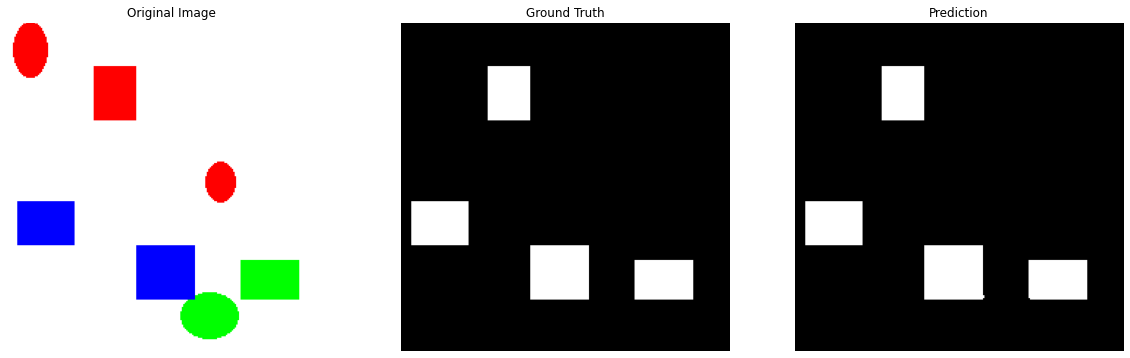

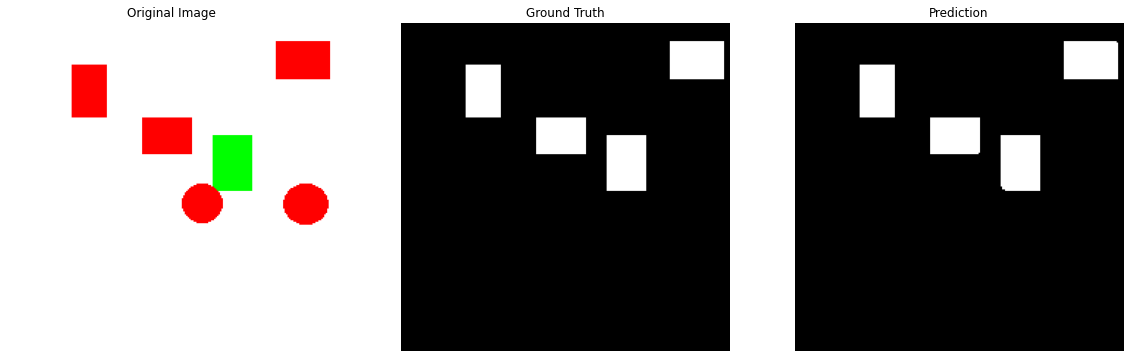

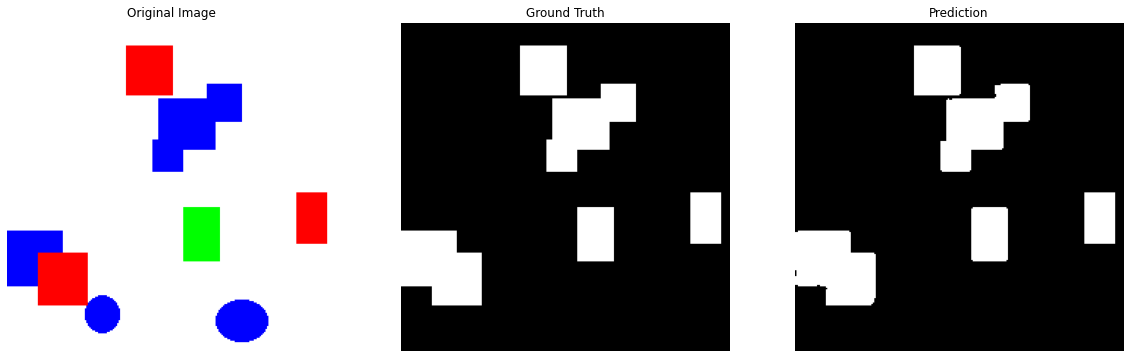

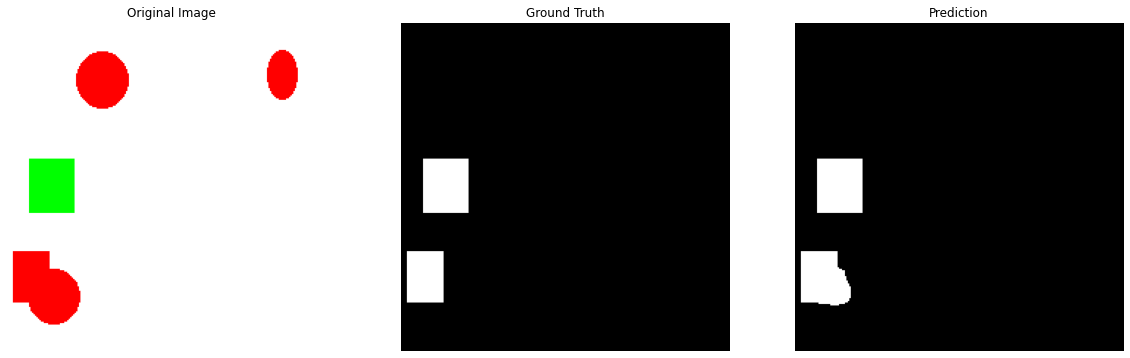

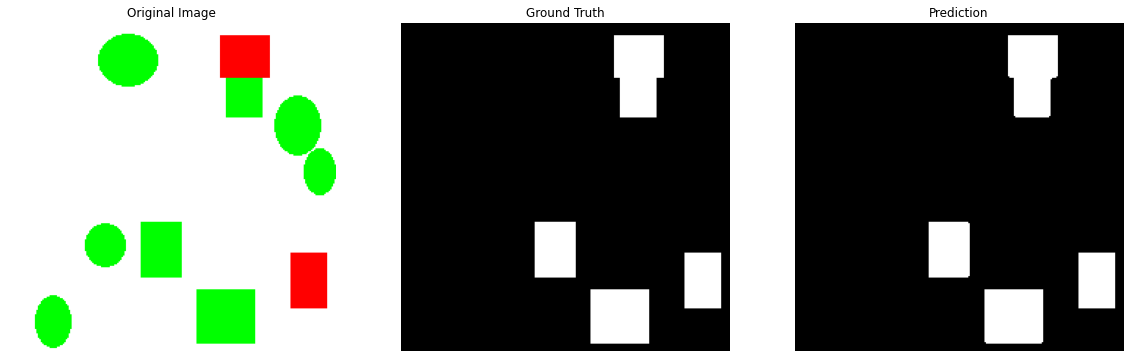

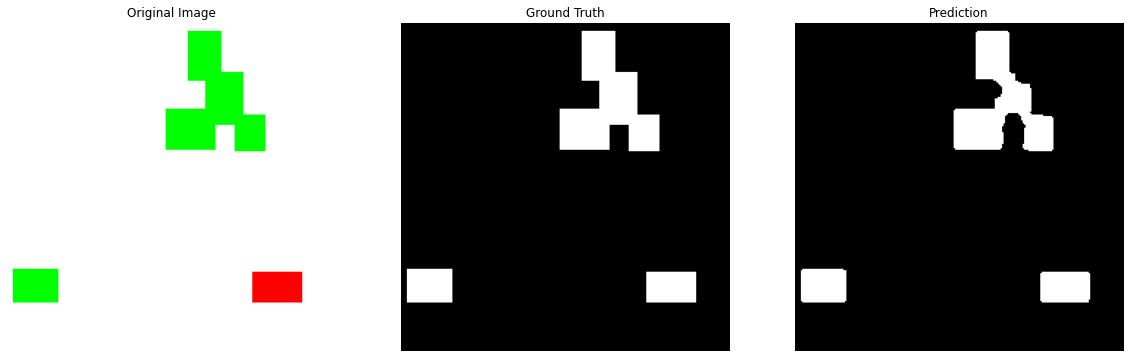

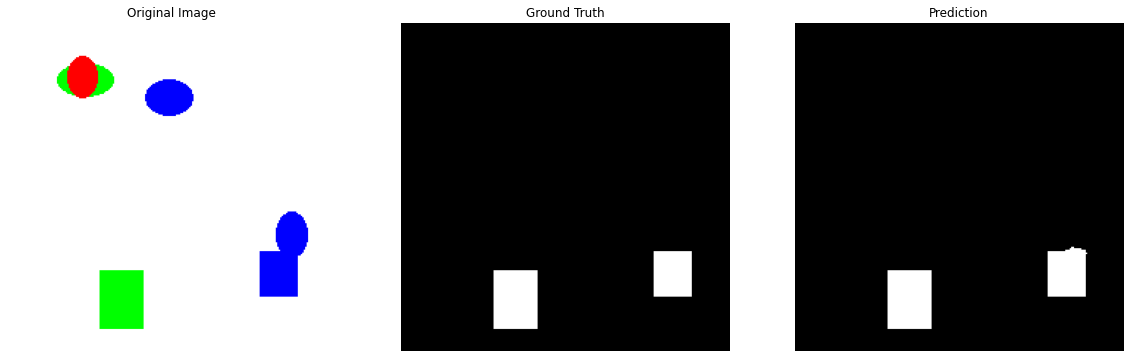

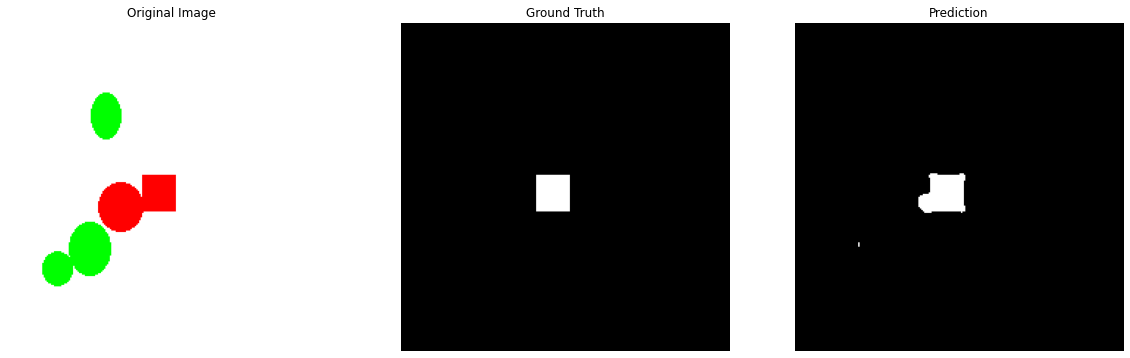

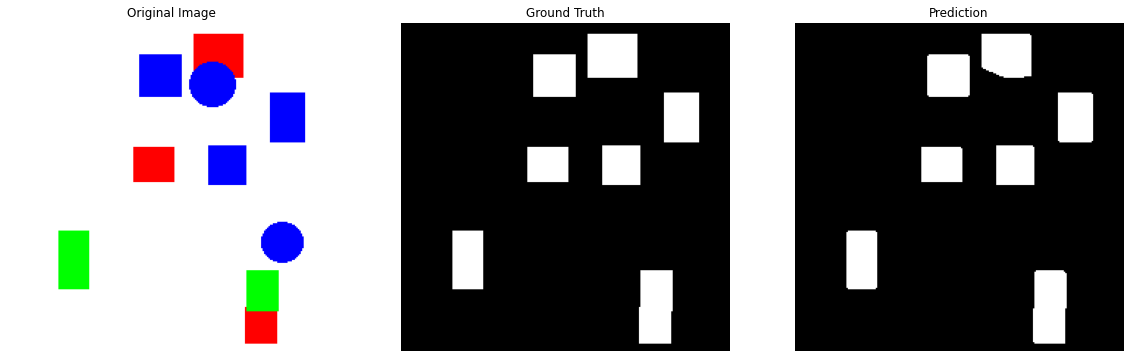

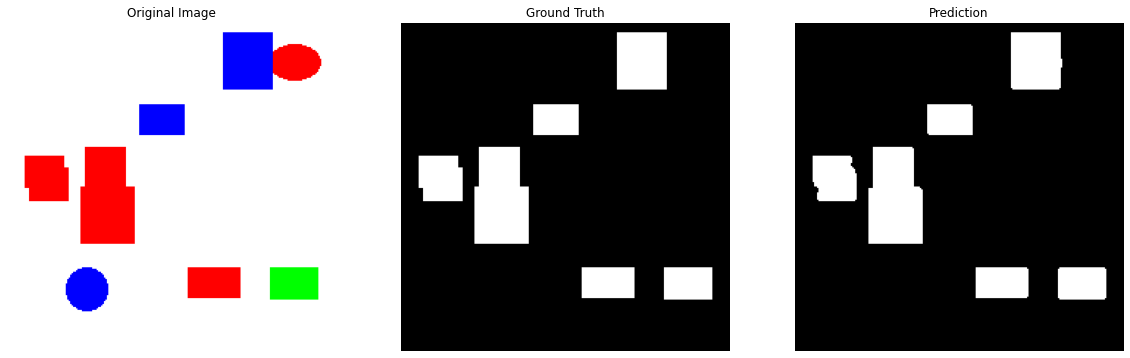

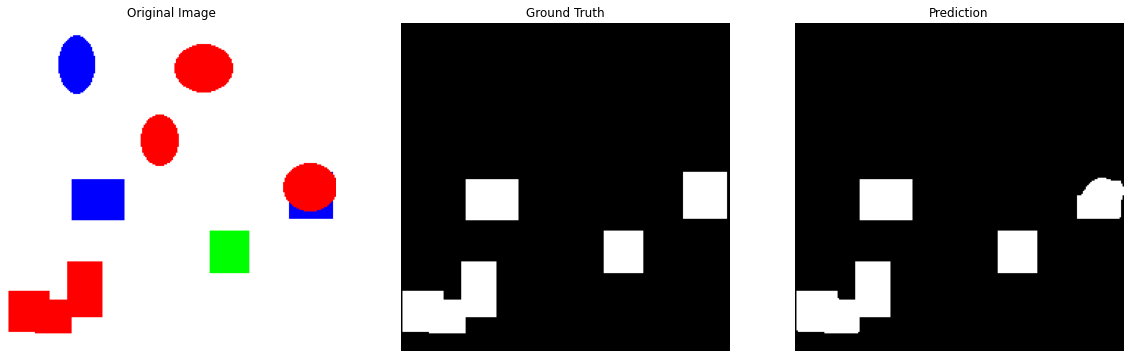

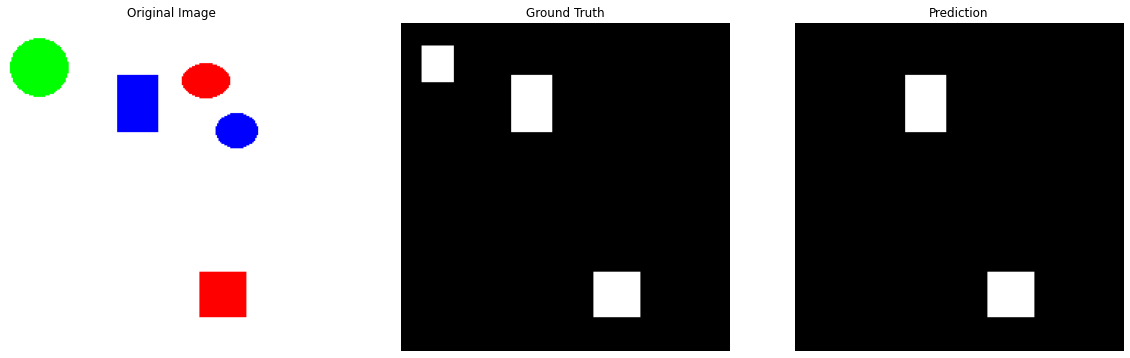

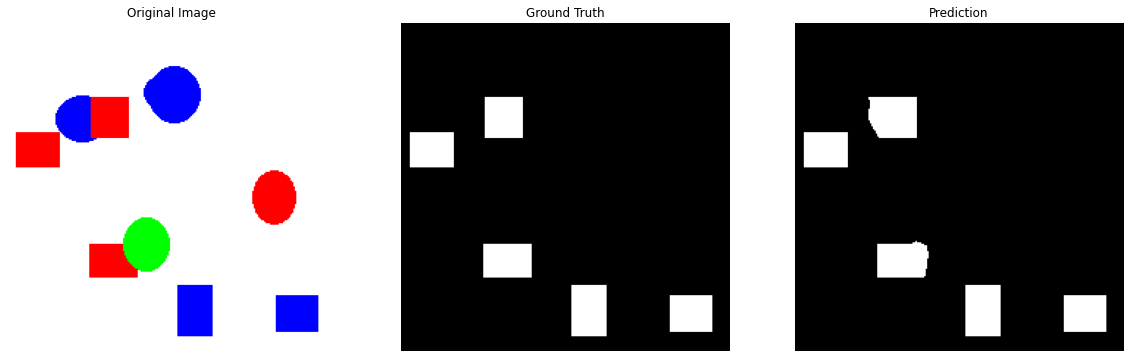

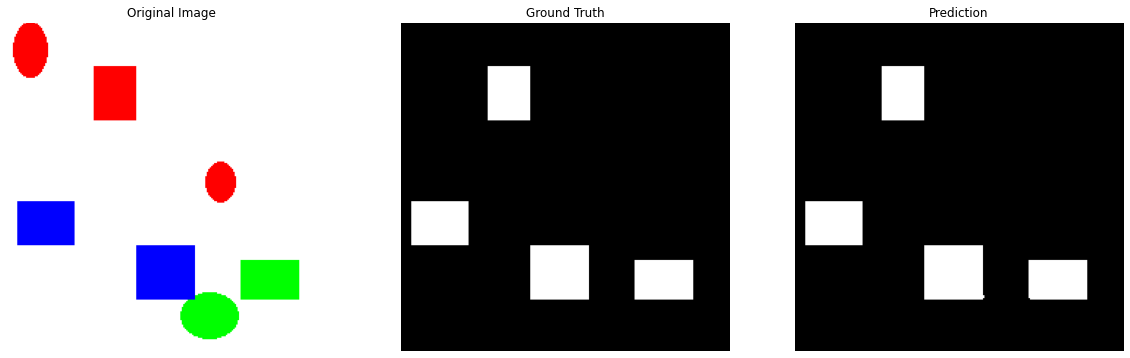

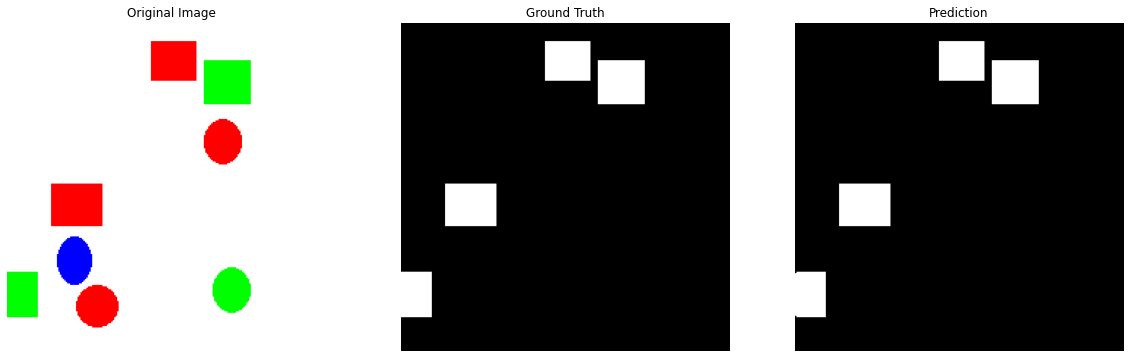

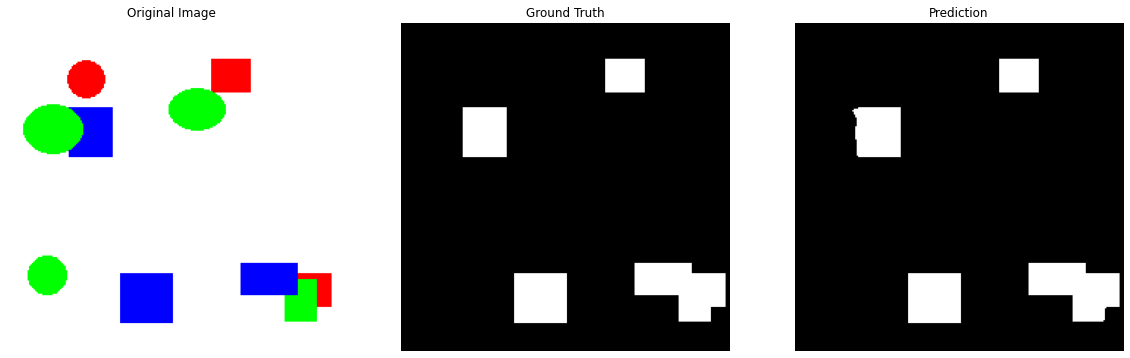

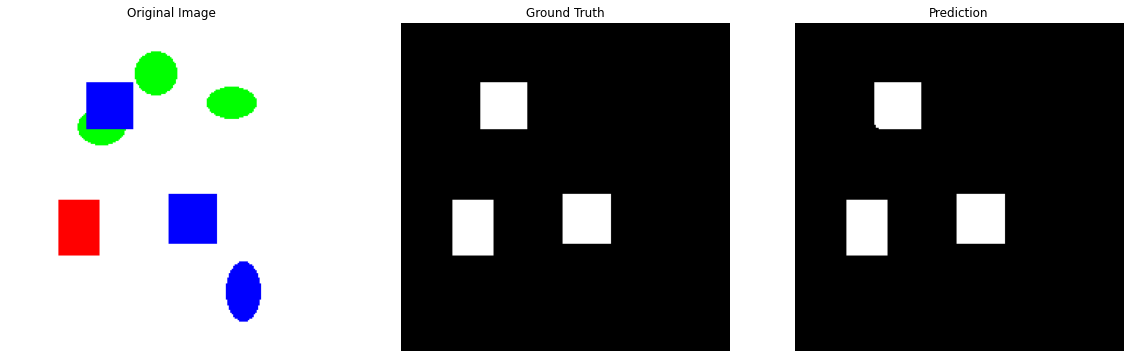

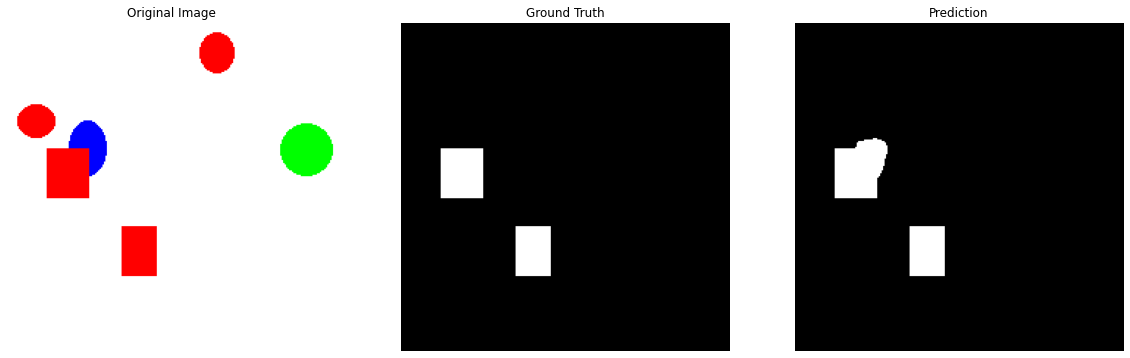

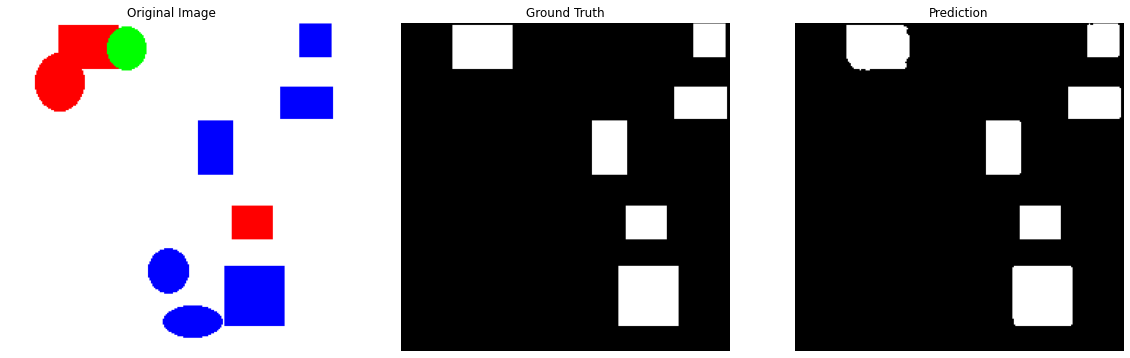

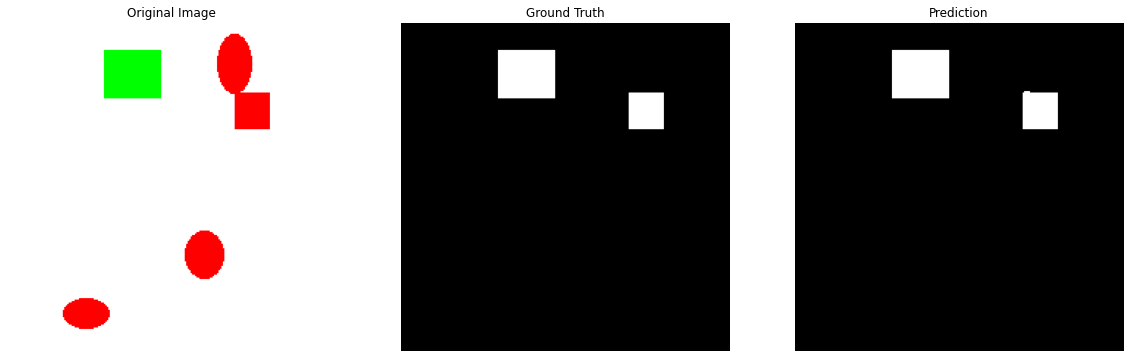

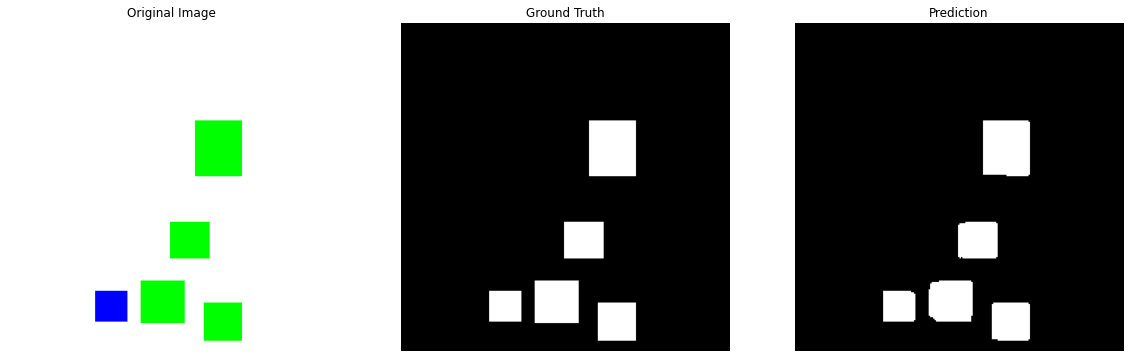

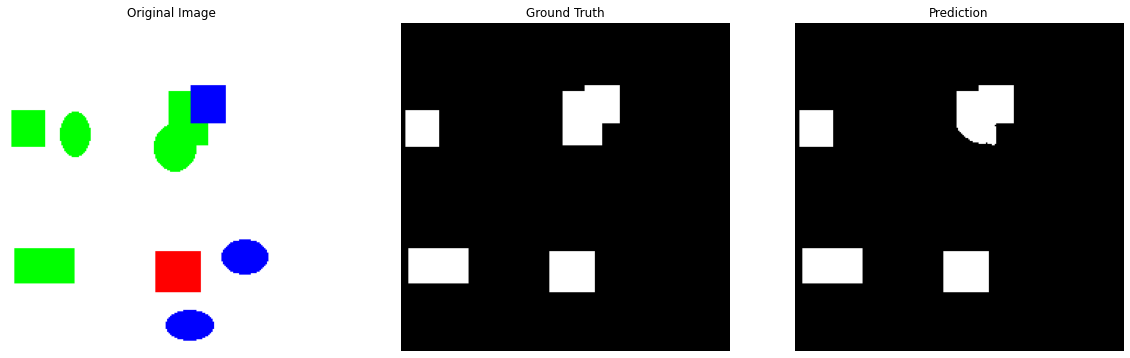

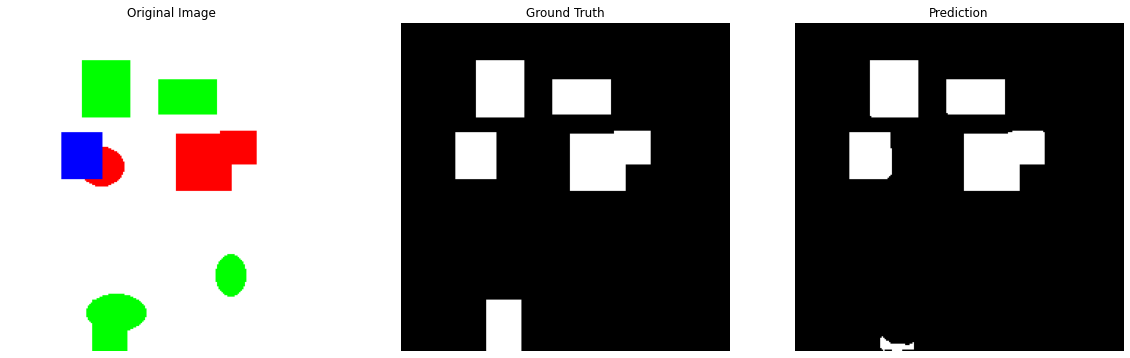

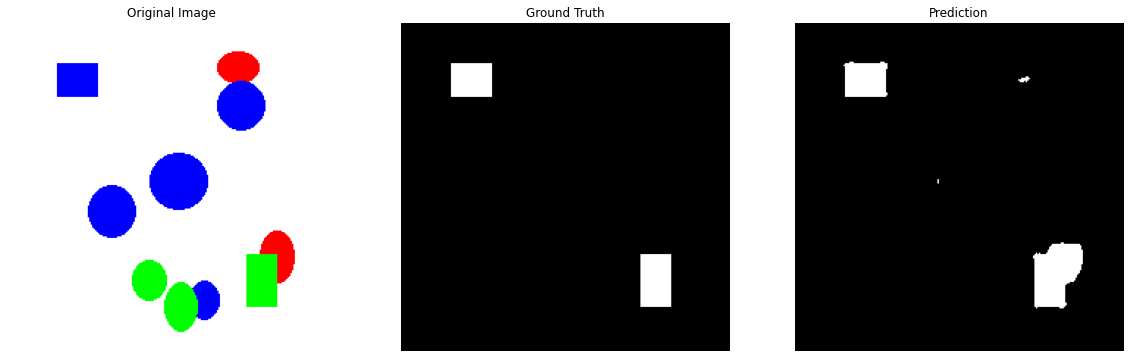

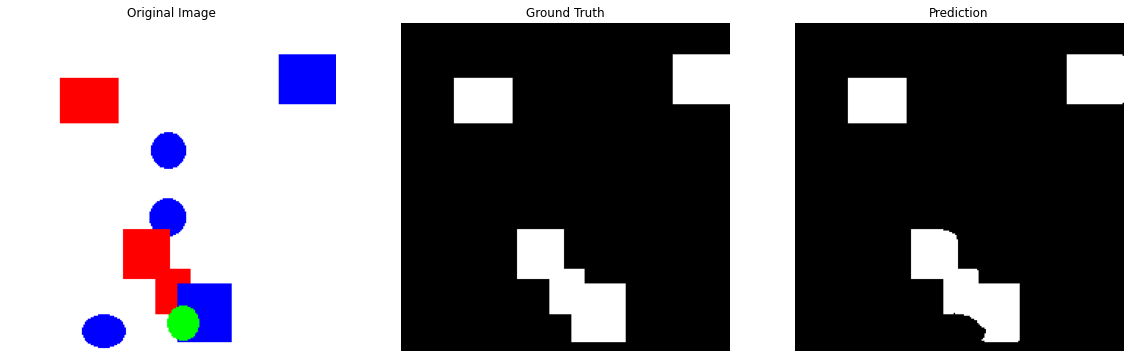

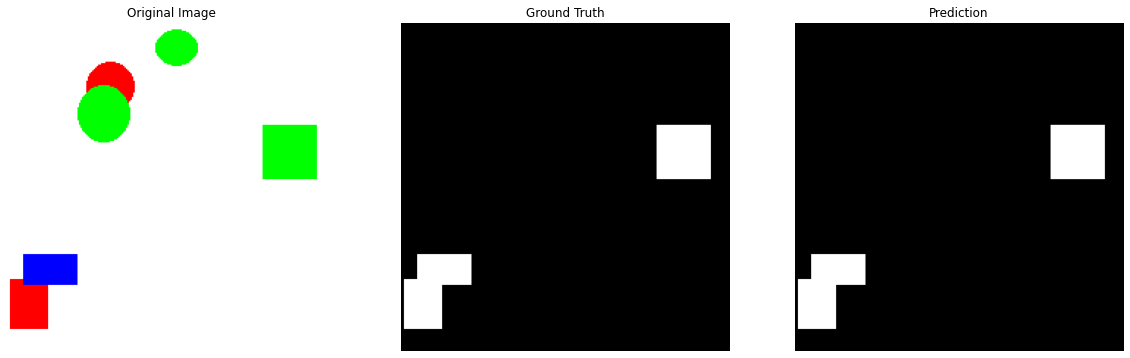

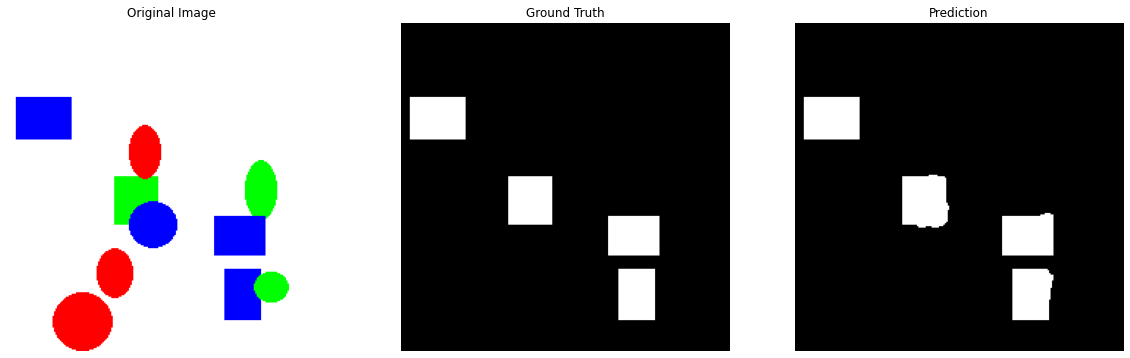

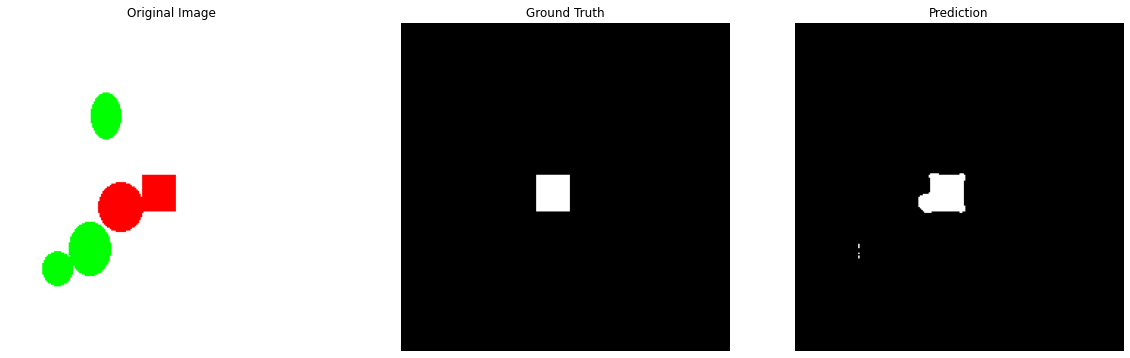

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
import matplotlib
matplotlib.use('Agg')


def visualize(image, ground_truth_mask, prediction):
    fig, axes = plt.subplots(1, 3, figsize=(20, 10))
    ax = axes.ravel()
    
    ax[0].imshow(image)
    ax[0].set_title('Original Image')
    ax[1].imshow(ground_truth_mask)
    ax[1].set_title('Ground Truth')
    ax[2].imshow(prediction)
    ax[2].set_title('Prediction')
    
    for a in ax:
        a.axis('off')
    
    plt.show()


for i in range(30):
    n = np.random.choice(len(testset))
    
    image, gt_mask = testset[n]
    imagevis, _ = testsetvis[n]
    
    image = image.unsqueeze(0)  
    pred = segmodel(image)
    pred = pred.squeeze(0).cpu().detach().numpy()
    gt_mask = gt_mask.permute(1, 2, 0).cpu().numpy().astype(np.uint8)
    
    reversed_gt_mask = reverse_one_hot(gt_mask)
    reversed_pred = np.argmax(pred, axis=0)  
    
    ground_truth_mask = colour_code_segmentation(reversed_gt_mask, class_rgb_values).astype(np.uint8)
    prediction = colour_code_segmentation(reversed_pred, class_rgb_values).astype(np.uint8)
    
    image_pil = transforms.ToPILImage()(imagevis.cpu())
    
    visualize(
        image=image_pil,
        ground_truth_mask=ground_truth_mask,
        prediction=prediction,
    )
